# 2. HR 1099 Positions

## 2.1. Notebook setup

In [1]:
import os
import sys

import emcee
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import smplotlib

In [2]:
epochs = ["A", "B", "C", "D", "E", "F"]
data_path = "../data/"
fig_path = "../figures/"
calibrator = "J0340"
target = "HR1099"

cm = ['#377eb8', '#e41a1c', '#4daf4a', '#dede00', '#ff7f00', '#999999', '#984ea3', '#f781bf', '#a65628']
marker_cycle = ["o", "v", "X", "<", "D", "^"]

sys.path.append(os.path.join(os.getcwd(), ".."))
from library import HR1099_astrometry, utils

deg = np.pi / 180
mas = deg / (60 * 60 * 1000)

## 2.2. Import data

In [3]:
mean_jd = np.genfromtxt(
        data_path + target + "_I_positions.txt",
        skip_header=2,
        dtype="U5,f8,f8,f8,f8,f8,f8,f8",
        usecols=(5),
        unpack=True)
mean_mjd = np.round(mean_jd - 2400000.5, 1)

target_results = {}
for epoch in epochs:
    x, y, jd, x_err, y_err = np.genfromtxt(
    data_path + epoch + "_" + target + "_I_sub-epoch_positions.txt",
    skip_header=2,
    dtype="U5,f8,f8,f8,f8,f8,f8,f8",
    usecols=(2, 3, 5, 6, 7),
    unpack=True)
    target_results[epoch] = np.array([x, y, jd, x_err, y_err])

sampler = emcee.backends.HDFBackend(data_path + target + "_orbital_chain.h5")
flat_samples = sampler.get_chain(flat=True)
flat_samples = np.divide(flat_samples, np.array([1, 1, deg, deg]))

med_val = np.percentile(flat_samples, [16, 50, 84], axis=0)
lower_val = med_val[1] - med_val[0]
upper_val = med_val[2] - med_val[1]
med_val = med_val[1]

hr1099 = HR1099_astrometry.HR1099_astrometry(med_val[2] * deg, med_val[3] * deg)
T, P, d, a, m1, m2, R1, R2 = hr1099.hr1099_info()

## 2.3. Plot

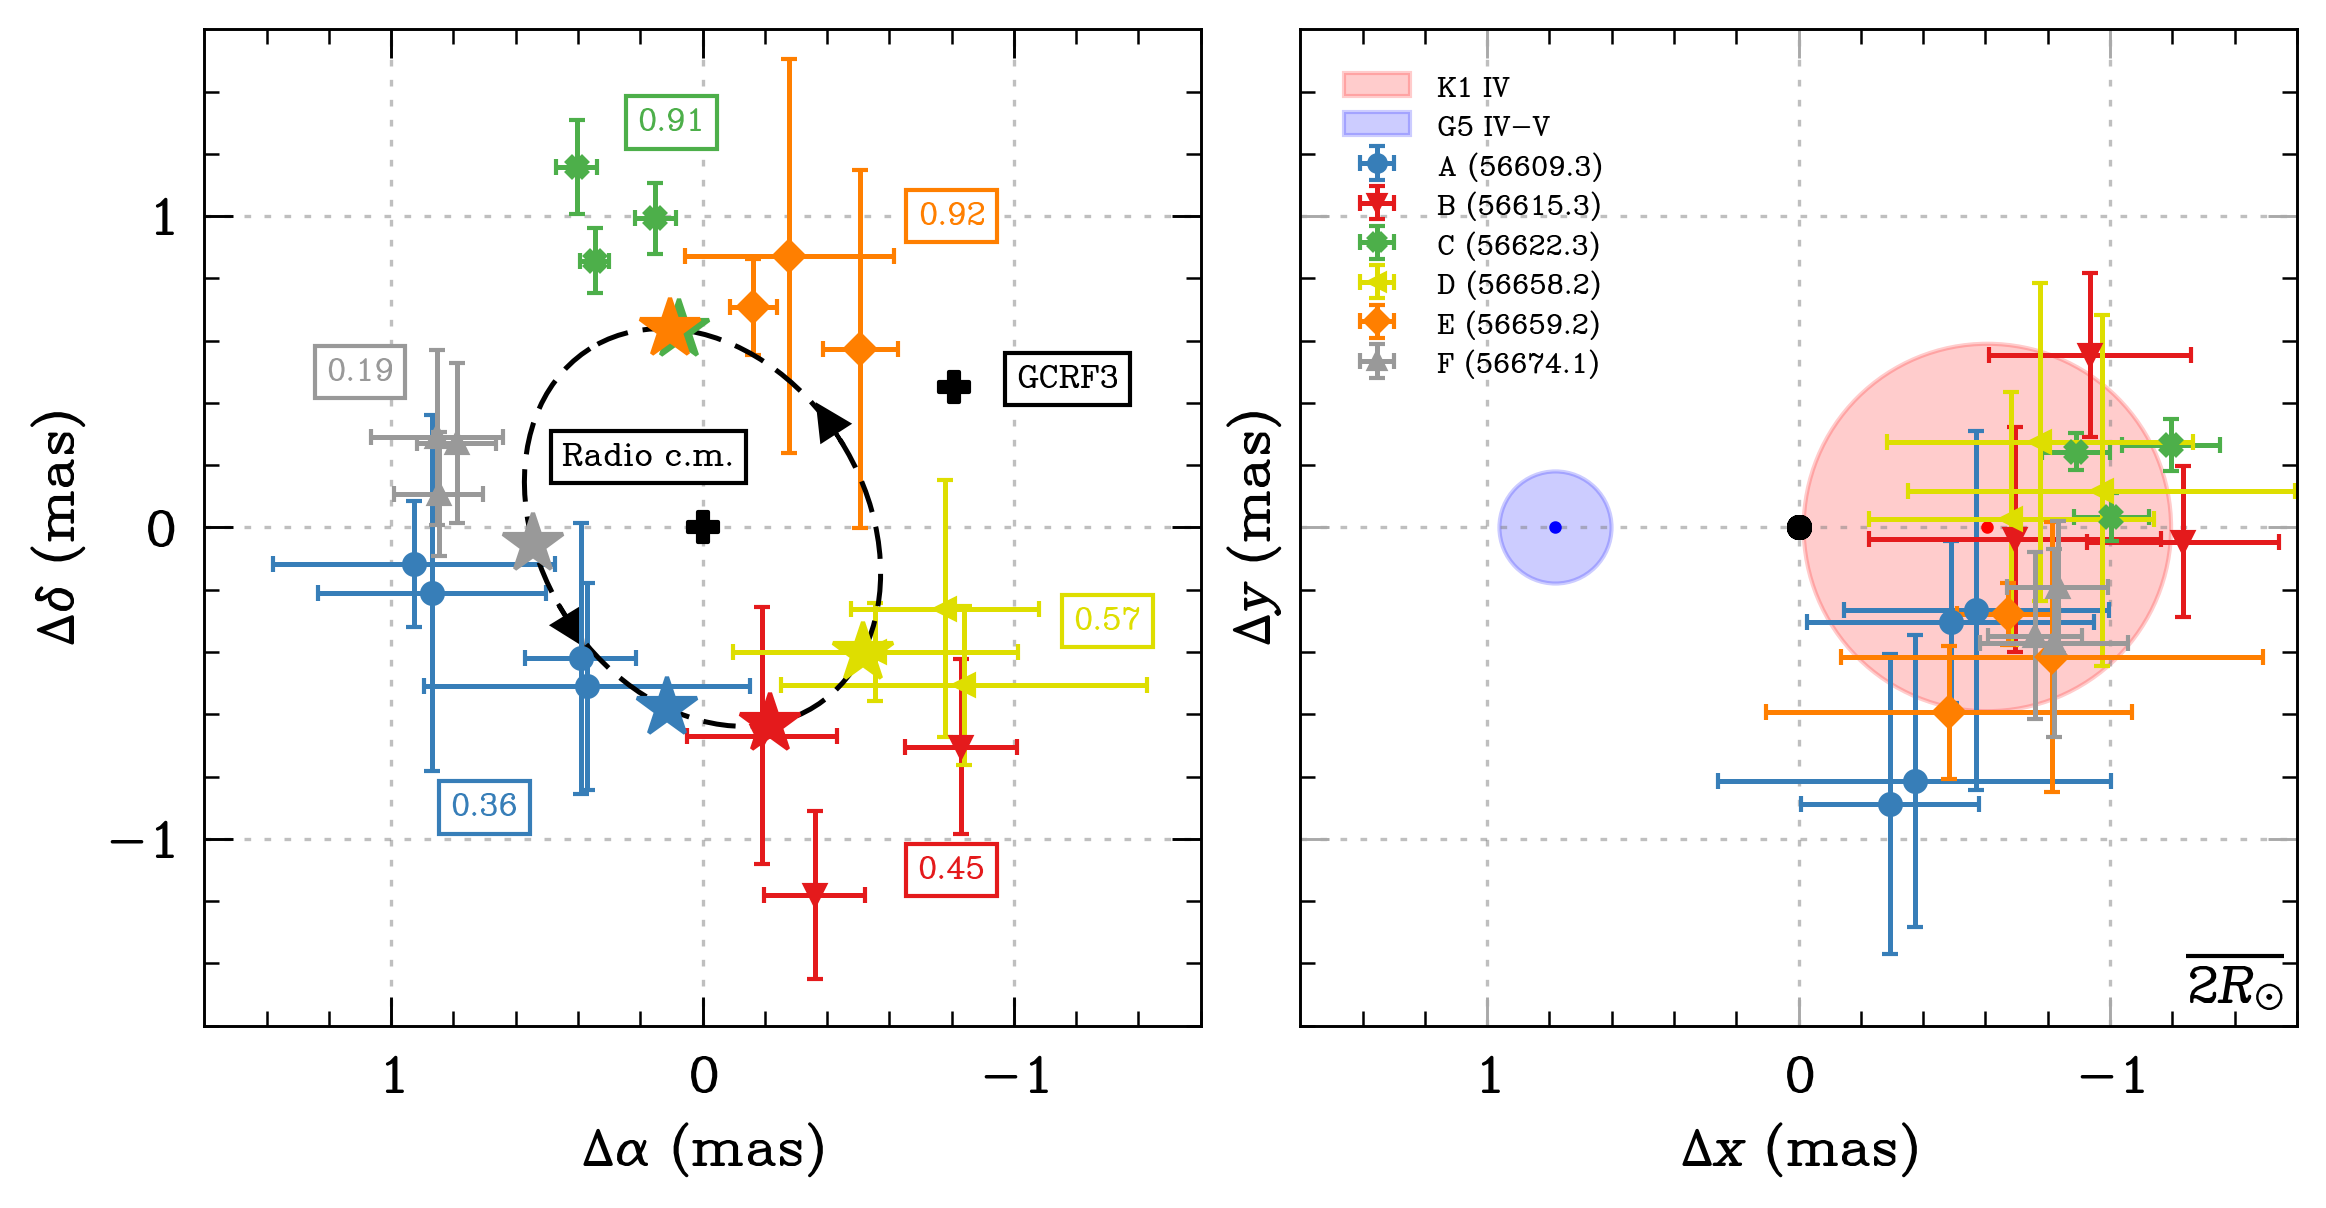

In [4]:
epoch_orbit_phases = []
for i, epoch in enumerate(epochs):
    epoch_orbit_phases.append(hr1099.orbit_phase(mean_jd[i]))
sorted_index = np.argsort(epoch_orbit_phases)

fig, ax = plt.subplots(1, 2, figsize=(9, 5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1)

for i, epoch in enumerate(epochs):
    ax[0].errorbar(
        target_results[epoch][0] + med_val[0],
        target_results[epoch][1] + med_val[1],
        xerr=target_results[epoch][3],
        yerr=target_results[epoch][4],
        marker=marker_cycle[i],
        markersize=5,
        linestyle="None",
        color=cm[i],
        label='%s (%.1f)' % (epoch, mean_jd[i]),
        )

    ra1, dec1, ra2, dec2, rho1, rho2, phi = hr1099.binary_offsets(mean_jd[i])
    ax[0].plot([ra1/mas], [dec1/mas], markersize=15, marker="*", 
        color=cm[i], zorder=3)

ax[0].annotate('%.2f' % epoch_orbit_phases[0], xy=(0.7, -0.9), fontsize=9, 
    bbox={"boxstyle":"square", "facecolor":"white", "edgecolor":cm[0]},
    color=cm[0], horizontalalignment="center", verticalalignment="center")
ax[0].annotate('%.2f' % epoch_orbit_phases[1], xy=(-0.8, -1.1), fontsize=9, 
    bbox={"boxstyle":"square", "facecolor":"white","edgecolor":cm[1]},
    color=cm[1], horizontalalignment="center", verticalalignment="center")
ax[0].annotate('%.2f' % epoch_orbit_phases[2], xy=(0.1, 1.3), fontsize=9, 
    bbox={"boxstyle":"square", "facecolor":"white","edgecolor":cm[2]},
    color=cm[2], horizontalalignment="center", verticalalignment="center")
ax[0].annotate('%.2f' % epoch_orbit_phases[3], xy=(-1.3, -0.3), fontsize=9, 
    bbox={"boxstyle":"square", "facecolor":"white","edgecolor":cm[3]},
    color=cm[3], horizontalalignment="center", verticalalignment="center")
ax[0].annotate('%.2f' % epoch_orbit_phases[4], xy=(-0.8, 1), fontsize=9, 
    bbox={"boxstyle":"square", "facecolor":"white","edgecolor":cm[4]},
    color=cm[4], horizontalalignment="center", verticalalignment="center")
ax[0].annotate('%.2f' % epoch_orbit_phases[5], xy=(1.1, 0.5), fontsize=9, 
    bbox={"boxstyle":"square", "facecolor":"white","edgecolor":cm[5]},
    color=cm[5], horizontalalignment="center", verticalalignment="center")

orbit_range = np.linspace(T, T + P/60/60/24, 100)
orbit_x = []
orbit_y = []
for t in orbit_range:
    ra1, dec1, ra2, dec2, rho1, rho2, phi = hr1099.binary_offsets(t)
    orbit_x.append(ra1/mas)
    orbit_y.append(dec1/mas)

ax[0].plot(orbit_x, orbit_y, color="black", linestyle="--")
ax[0].arrow(orbit_x[24], orbit_y[24], orbit_x[25]-orbit_x[24], orbit_y[25]-orbit_y[24],
            head_width=0.1, head_length=0.1, fc="black", ec="black")
ax[0].arrow(orbit_x[74], orbit_y[74], orbit_x[75]-orbit_x[74], orbit_y[75]-orbit_y[74],
            head_width=0.1, head_length=0.1, fc="black", ec="black")

ax[0].scatter([0], [0], marker="P", color="black", zorder=2, s=50)
ax[0].annotate("Radio c.m.", xy=(0.45, 0.2), fontsize=9, bbox={"boxstyle":"square", "facecolor":"white",
    "edgecolor":"black"}, zorder=2)
ax[0].scatter([med_val[0]], [med_val[1]], marker="P", color="black", zorder=2, s=50)
ax[0].annotate("GCRF3", xy=(med_val[0]-0.2, med_val[1]), xycoords="data",
    fontsize=9, bbox={"boxstyle":"square", "facecolor":"white",
    "edgecolor":"black"}, zorder=2)

ax[0].set_xlim(1.6, -1.6)
ax[0].set_ylim(-1.6, 1.6)
ax[0].xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax[0].yaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax[0].set_xlabel(r"$\Delta \alpha$ (mas)")
ax[0].set_ylabel(r"$\Delta \delta$ (mas)")
ax[0].grid(True, linestyle="dotted", alpha=0.5)
ax[0].set_aspect("equal")

utils.plot_binary(ax[1], hr1099, T + 0.375 * P/60/60/24, corotate=True, plot_stars=True, d=d)

all_epochs = np.concatenate([[epoch]*len(target_results[epoch][0]) for epoch in epochs])
all_x = np.concatenate([target_results[epoch][0] for epoch in epochs])
all_y = np.concatenate([target_results[epoch][1] for epoch in epochs])
all_jd = np.concatenate([target_results[epoch][2] for epoch in epochs])
all_x_err = np.concatenate([target_results[epoch][3] for epoch in epochs])
all_y_err = np.concatenate([target_results[epoch][4] for epoch in epochs])

for i, epoch in enumerate(all_epochs):
    utils.plot_binary(
        ax[1],
        hr1099,
        mean_jd[epochs.index(epoch)],
        corotate=True,
        plot_stars=False,
        centroid=[all_x[i]+med_val[0], all_y[i]+med_val[1], all_x_err[i], all_y_err[i]],
        label='%s (%.1f)' % (epoch, mean_mjd[epochs.index(epoch)]),
        color=cm[epochs.index(epoch)],
        mapsize=4,
        marker=marker_cycle[epochs.index(epoch)],
    )
ax[1].set_xlabel(r"$\Delta x$ (mas)")
ax[1].set_ylabel(r"$\Delta y$ (mas)")
ax[1].set_xlim(1.6, -1.6)
ax[1].set_ylim(-1.6, 1.6)
ax[1].grid(True, linestyle="dotted", alpha=0.5)
ax[1].set_aspect("equal")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[1].legend(by_label.values(), by_label.keys(), loc="upper left", fontsize=8, markerscale=0.8)

fig.set_facecolor("white")
fig.set_dpi(300)
fig.savefig(fig_path + "HR1099_positions.pdf", bbox_inches="tight")
plt.show()